## UMAP MNMG Visualization

In [4]:
from cuml.dask.manifold import UMAP as UMAP_MNMG
from cuml.manifold import UMAP
from cuml.metrics import trustworthiness

from dask_cuda import LocalCUDACluster
from dask.distributed import Client
import dask.array as da

import pickle
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def distribute_data(data, n_parts, sampling_ratio):
    n_samples = data.shape[0]
    
    # Number of samples for local train
    n_to_sample = int(n_samples * sampling_ratio)

    # Generate local train data
    selection = np.random.choice(n_samples, n_to_sample)
    lX = data[selection]

    # Number of samples per partition
    n_samples_per_part = int(n_samples / n_parts)

    # Generate partitioning of distributed data for inference
    chunks = [n_samples_per_part] * n_parts
    chunks[-1] += n_samples % n_samples_per_part
    chunks = tuple(chunks)
    dX = da.from_array(data, chunks=(chunks, -1))
    
    return lX, dX

In [28]:
def plot_umap_mnmg(args, X, y):
    fig, ax = plt.subplots(len(args['sampling_ratio']), len(args['n_parts']),
                           sharex='col', sharey='row', figsize=(20,27))
    fig.subplots_adjust(wspace=0.1, hspace=0.15)
    fig.suptitle('Comparison of Sampling Ratios and Partitioning in Distributed UMAP', y=0.9, size=20)
    
    for a, n_parts in zip(ax[0], args['n_parts']):
        a.set_title("Partitions: {}".format(n_parts))

    for a, sampling_ratio in zip(ax[:,0], args['sampling_ratio']):
        a.set_ylabel("Sampling: {:.2f}%".format(sampling_ratio * 100), rotation=0, size='large', labelpad=45)
    
    if n_parts > 1:
        cluster = LocalCUDACluster(n_workers=8, threads_per_worker=1)
        client = Client(cluster)
    
    for i, n_parts in enumerate(args['n_parts']):
        for j, sampling_ratio in enumerate(args['sampling_ratio']):        
            if n_parts == 1: # Local transformation
                local_model = UMAP(n_components=2, n_neighbors=args['n_neighbors'],
                                   n_epochs=args['n_epochs'], random_state=args['random_state'])
                
                # Generate subsample for training data
                n_samples = X.shape[0]
                n_to_sample = int(n_samples * sampling_ratio)
                selection = np.random.choice(n_samples, n_to_sample)
                train_data = X[selection]
                
                # Run fit with subsample and transform with full data
                local_model.fit(train_data)
                transformed = local_model.transform(X)
            else: # Distributed transformation
                
                # Distribute data
                lX, dX = distribute_data(X, n_parts, sampling_ratio)

                # Train local model
                local_model = UMAP(n_components=2, n_neighbors=args['n_neighbors'],
                                   n_epochs=args['n_epochs'], random_state=args['random_state'])
                local_model.fit(lX)
                
                # Pass trained model and perform distributed inference
                model = UMAP_MNMG(local_model, random_state=args['random_state'])
                transformed = model.transform(dX).compute()
            
            trust_score = trustworthiness(X, transformed, n_neighbors=args['n_neighbors'])
            
            # Plot transformed data
            subplot = ax[j, i]
            subplot.scatter(transformed[:,0], transformed[:,1], c=y,
                             s=0.2, alpha=0.3, edgecolors='none')
            trust_score_text = "Trust: " + str(round(trust_score, 4))
            subplot.text(0.5,-0.1, trust_score_text, size=14, ha="center", transform=subplot.transAxes)
            
    if n_parts > 1:
        client.close()
        cluster.close()

### Preprocess tasic2018 dataset
Generate the preprocessed dataset with the tasic2018_dataset_preprocessing.ipynb notebook in the tasic2018 directory

In [29]:
X = pickle.load(open("tasic2018/tasic2018_X.p", "rb"))
y = pickle.load(open("tasic2018/tasic2018_y.p", "rb"))

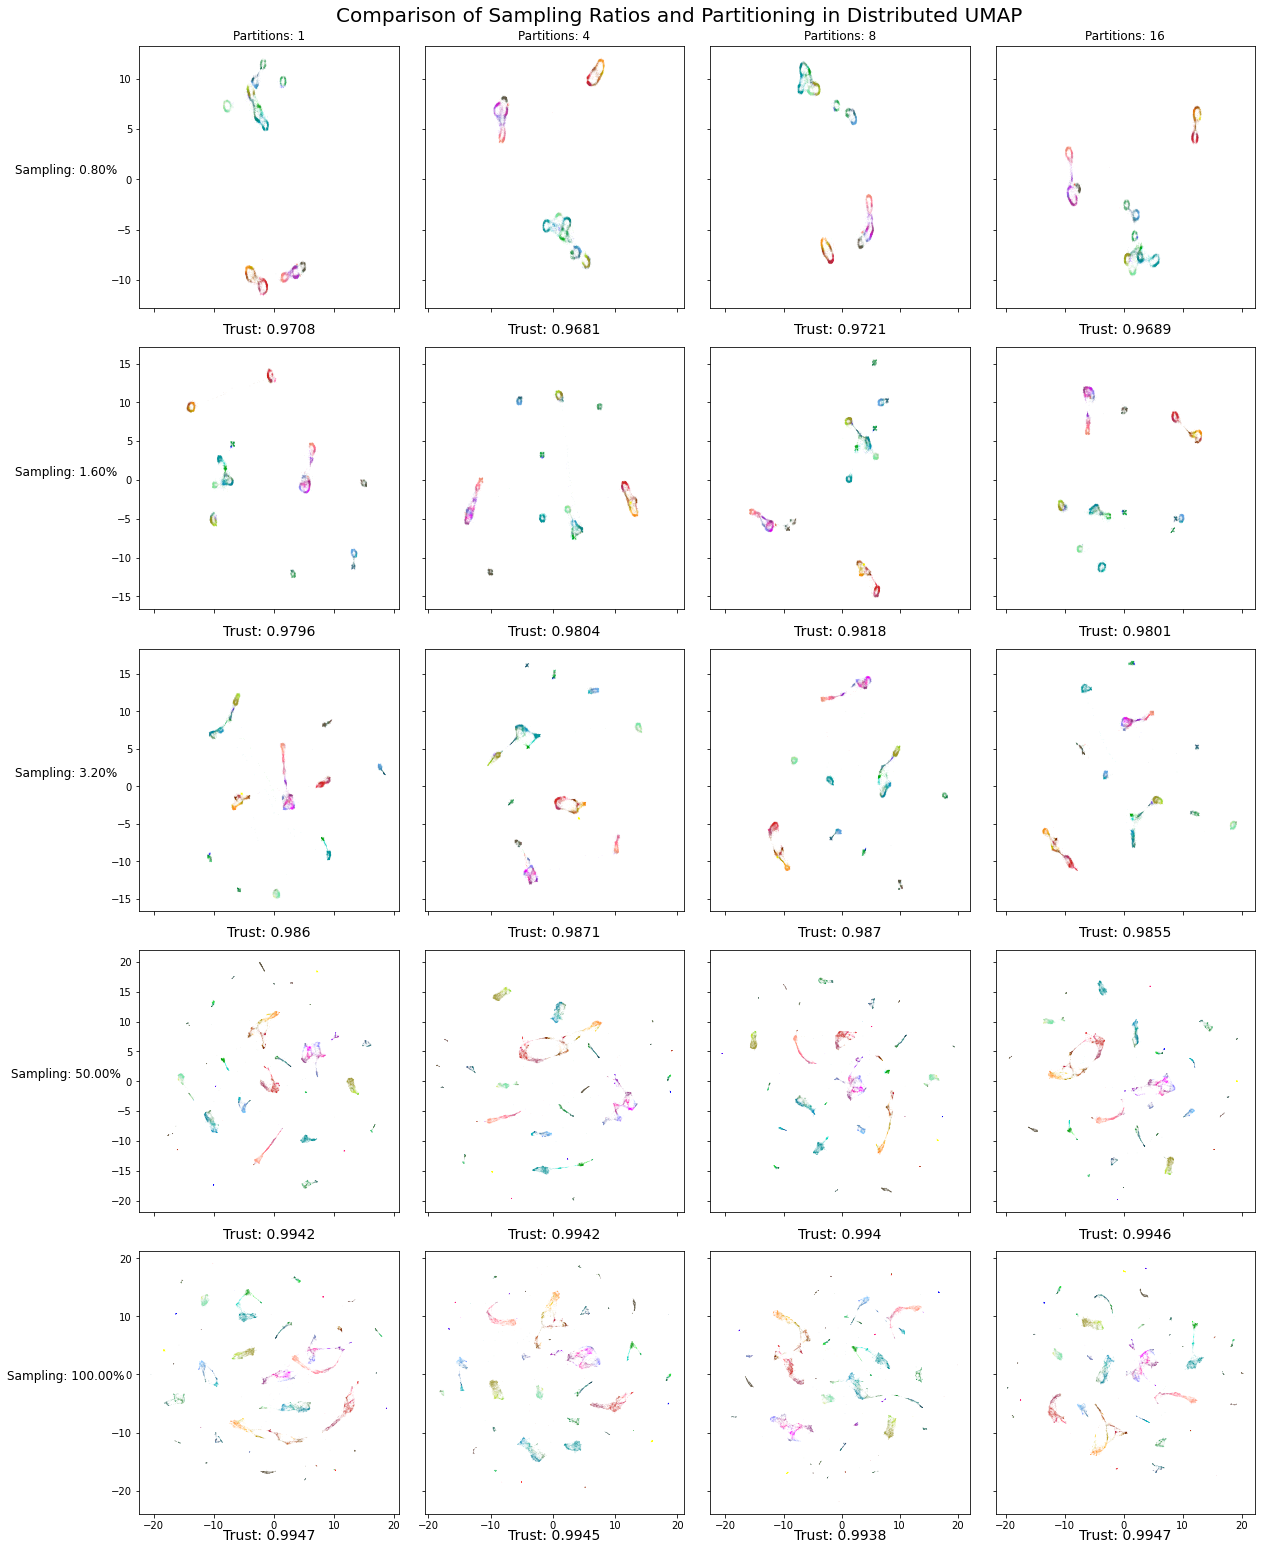

In [31]:
import warnings
warnings.filterwarnings('ignore')

args = {'n_neighbors': 15, 'n_epochs': 500, 'random_state': 42,
        'n_parts':[1,4,8,16], 'sampling_ratio': [0.008,0.016,0.032,0.5,1.0]}

plot_umap_mnmg(args, X, y)